# Multikernel

This notebooks demonstrates how to use the multi-kernel feature, combining a Gaussian kernel with a linear kernel and a polynomial kernel (order 2).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster

from hsic_optimization.benchmark import generate_data
from hsic_optimization.hsic_lasso import cd_hsic_lasso, feature_multikernel

## Dataset and parameter generation

We generate a small dataset to demonstrate the method.

In [2]:
block_size = 20
n_repeats = 3

n_samples = 1000
n_features = 100
n_active = 10

X, Y = generate_data(n_samples, n_features, n_active, seed=1234, transpose_X=True)

And we define the CD solver parameters common to all tested cases.

In [3]:
cd_hsic_kwargs = {
    "Y": Y,
    "B": block_size,
    "M": n_repeats,
    "num_feat": 10,
    "feature": feature_multikernel,
    "n_repeat": 3,
}

## Serial code 

In [4]:
%%time
path_serial, beta_serial, lams_serial = cd_hsic_lasso(X, **cd_hsic_kwargs)
path_serial = path_serial.toarray()

CPU times: user 2.5 s, sys: 27.4 ms, total: 2.53 s
Wall time: 2.53 s


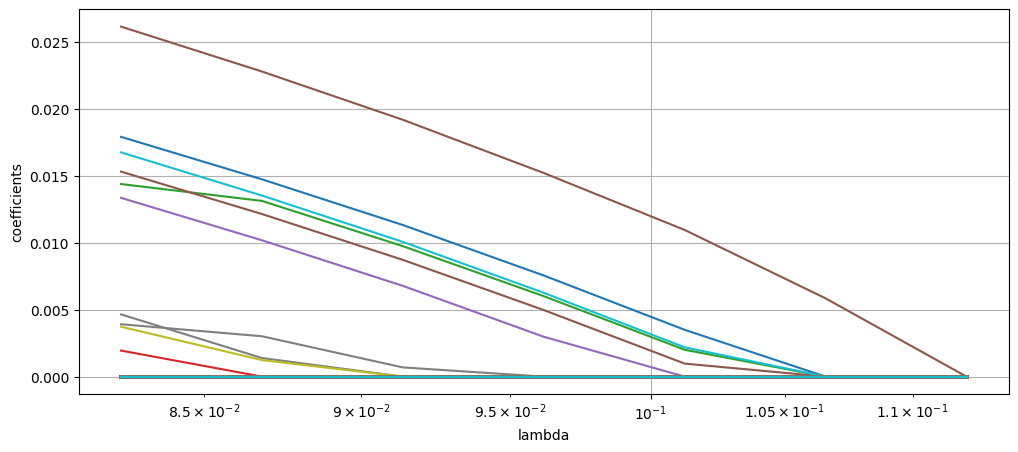

In [5]:
_, ax = plt.subplots(figsize=(12, 5))
ax.plot(lams_serial, path_serial)
ax.set_xlabel("lambda")
ax.set_ylabel("coefficients")
ax.set_xscale("log")
ax.grid()

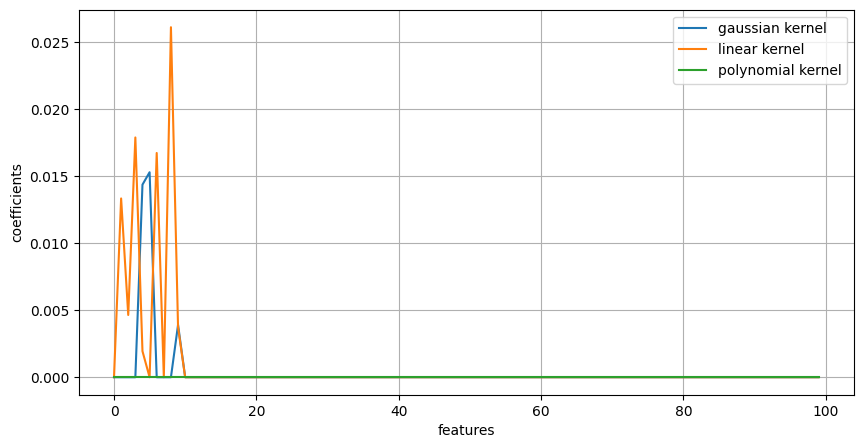

In [6]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(beta_serial[::3], label="gaussian kernel")
ax.plot(beta_serial[1::3], label="linear kernel")
ax.plot(beta_serial[2::3], label="polynomial kernel")
ax.set_xlabel("features")
ax.set_ylabel("coefficients")
ax.legend()
ax.grid()

Let's check how many of the original features have at least one of the kernel features with a non-zero values.

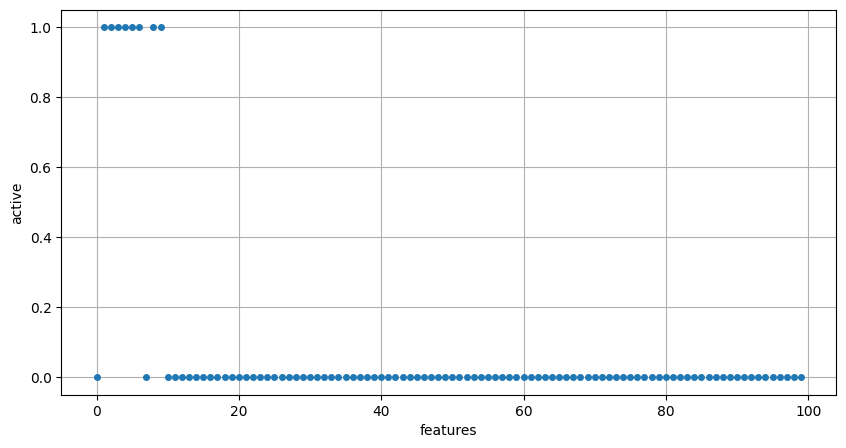

In [7]:
beta_active = (beta_serial > 0).reshape(-1, 3).any(1)

_, ax = plt.subplots(figsize=(10, 5))
ax.plot(beta_active, "o", ms=4)
ax.set_xlabel("features")
ax.set_ylabel("active")
ax.grid()

## Parallel code

In [8]:
cluster = LocalCluster(
    n_workers=4,
    threads_per_worker=1,
    memory_limit="1GiB",
    processes=True,
    local_directory="../dask",
)
client = Client(cluster)

/home/riom/project/hsic_optimization/venv/lib/python3.10/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34880 instead
  warnings.warn(


In [9]:
def raw_feature(i):
    return X[i]

In [10]:
%%time
path_par, beta_par, lams_par = cd_hsic_lasso(
    raw_feature, n_features=len(X), client=client, **cd_hsic_kwargs
)
path_par = path_par.toarray()

CPU times: user 1min 54s, sys: 15.1 s, total: 2min 10s
Wall time: 1min 57s


In [11]:
cluster.close()
client.close()

In [12]:
max_diff = np.max(np.abs(beta_par - beta_serial))
print("Maximum difference between parallel and serial code results:", max_diff)

Maximum difference between parallel and serial code results: 0.0


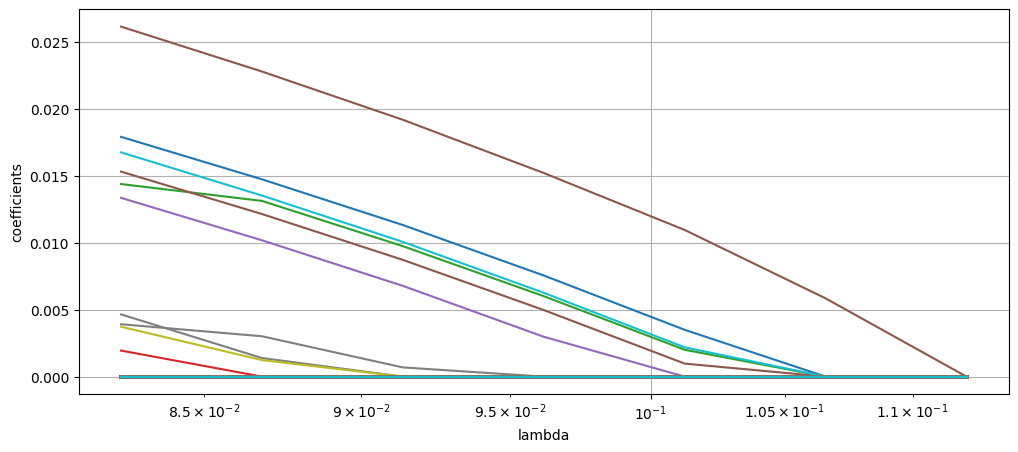

In [13]:
_, ax = plt.subplots(figsize=(12, 5))
ax.plot(lams_par, path_par)
ax.set_xlabel("lambda")
ax.set_ylabel("coefficients")
ax.set_xscale("log")
ax.grid()